In [8]:
import matplotlib.pyplot as plt

from skimage import data, color, img_as_ubyte
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
from skimage import io
import util as ut
import cv2
import numpy as np
import math


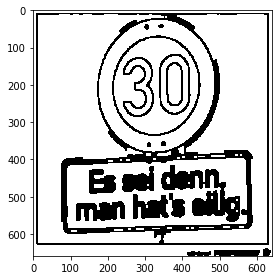

In [9]:
# Load picture, convert to grayscale and detect edges
# image_rgb = io.imread("Verkehrsschilderkenner/Verkehrsschilder.jpg")
image_rgb = io.imread("Verkehrsschilderkenner/30_test_4.jpg")
# image_gray = image_rgb[:,:,2]
image_gray = ut.rgb2gray(image_rgb).astype('uint8')
edges = cv2.Canny(image_gray, threshold1=100, threshold2=300)
kernel = np.ones((5,5),np.uint8)
dilate = cv2.dilate(edges,kernel,iterations = 2)
erosion = cv2.erode(dilate,kernel,iterations = 1)
edged = np.invert(erosion)
ut.printImage(edged)

In [10]:
contours, _ =  cv2.findContours(edged, 1, 2)

In [11]:
minThresE = 10000
maxThresE = 150000
count = 0
elipse_list = []
t_img = image_gray.copy()
for cnt in contours:
    try:
        area = cv2.contourArea(cnt)
        if minThresE < area < maxThresE:
            
            ellipse = cv2.fitEllipse(cnt)
            
            x, y = ellipse[0]
            a, b = ellipse[1] 
            angle = ellipse[2]
            elipse_list.append(((x, y), (a, b), angle))

            a = a / 2
            b = b / 2
            cv2.ellipse(t_img, (int(x), int(y)), (int(a), int(b)), int(angle), 0.0, 360.0,(255), 1)
            count += 1
    except:
        continue
cv2.imshow("4-findEllipse", t_img)
cv2.waitKey(0)
print(count)
print(len(contours))



8
62


((450.0062255859375, 490.20245361328125), (110.576171875, 207.16468811035156), 118.72093963623047)


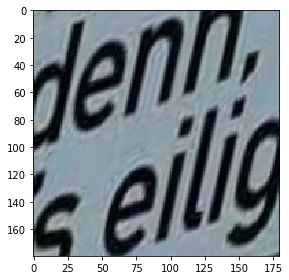

((320.009765625, 492.3556213378906), (181.8268585205078, 737.9877319335938), 87.93353271484375)


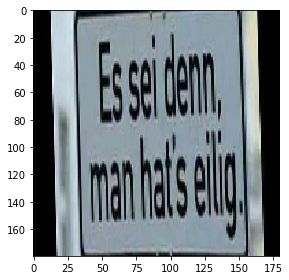

((378.5754699707031, 198.3323211669922), (97.77996063232422, 170.25076293945312), 0.055209409445524216)


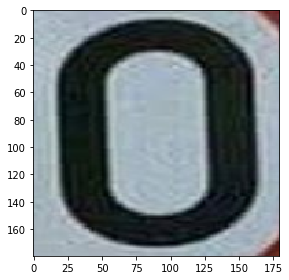

((329.574462890625, 202.7707061767578), (223.5315704345703, 257.38690185546875), 9.049644470214844)


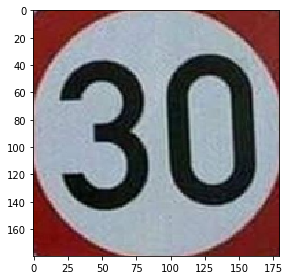

((329.55560302734375, 202.68283081054688), (238.1971893310547, 272.3467712402344), 8.817218780517578)


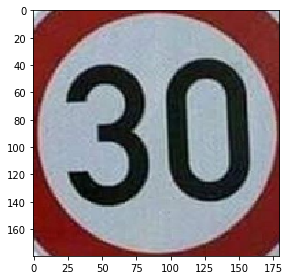

((330.93841552734375, 202.6387176513672), (306.3807067871094, 352.6226806640625), 9.002422332763672)


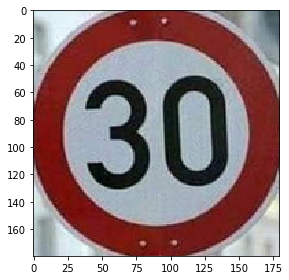

((471.7424011230469, 340.9284973144531), (301.5141296386719, 617.5614624023438), 179.55630493164062)


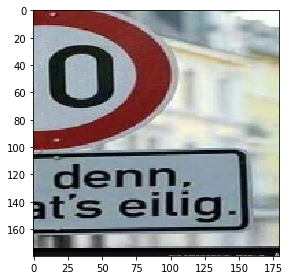

((231.0982208251953, 310.59002685546875), (430.7178955078125, 606.3825073242188), 14.484813690185547)


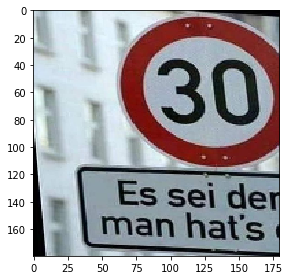

In [18]:
from math import sin, cos

def rotate(origin, point, angle):
	#Rotate a point counterclockwise by a given angle around a given origin.
	#The angle should be given in radians.
	x = origin[0] + cos(angle) * (point[0] - origin[0]) - sin(angle) * (point[1] - origin[1])
	y = origin[1] + sin(angle) * (point[0] - origin[0]) + cos(angle) * (point[1] - origin[1])
	return [x, y]

def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	x = pts[0][0]
	y = pts[0][1]
	a = pts[1][0] / 2
	b = pts[1][1] / 2
	angle = pts[2]
	points = (rotate((0,0), (a, 0), math.radians(angle) ),
			  rotate((0,0), (-a, 0), math.radians(angle)),
			  rotate((0,0), (0,b), math.radians(angle)),
			  rotate((0,0), (0,-b), math.radians(angle)))

	elipse_pts = np.array([
		[points[0][0]+ x, points[0][1] + y],
		[points[1][0]+ x, points[1][1] + y],
		[points[2][0]+ x, points[2][1] + y],
		[points[3][0]+ x, points[3][1] + y]], dtype = "float32")

	maxWidth = 180
	maxHeight = 180

	dst_pts = (
		rotate((0, 0), (90, 0), math.radians(angle)),
		rotate((0, 0), (-90, 0), math.radians(angle)),
		rotate((0, 0), (0, 90), math.radians(angle)),
		rotate((0, 0), (0, -90), math.radians(angle)))

	dst = np.array([
		[dst_pts[0][0]+ 90, dst_pts[0][1] + 90],
		[dst_pts[1][0]+ 90, dst_pts[1][1] + 90],
		[dst_pts[2][0]+ 90, dst_pts[2][1] + 90],
		[dst_pts[3][0]+ 90, dst_pts[3][1] + 90]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(elipse_pts, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped

new_imges = []
for el in elipse_list:
	print(el)
	new_img = four_point_transform(image_rgb, el)
	new_imges.append(new_img)
	ut.printImage(new_img)

In [13]:
import util_verkehrsschilderkenner as ut2
img_ref = ut.rgb2gray(io.imread("Verkehrsschilderkenner/30_ref.jpg"))

result_list = []
result_list2 = []

for entry in new_imges:
    tmp_res = ut2.match_signs(entry, img_ref, version=2)
    result_list.append(tmp_res[0])
    result_list2.append(tmp_res[1])



In [14]:
print(result_list)

[0.032322373, -0.02869572, 0.080975346, -0.10562921, -0.15796834, 0.71060085, 0.012591169, 0.039670352]
